<a href="https://colab.research.google.com/github/RTCChen/NegiScanAgent/blob/main/NegiScanAgent_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦾 **NegiScanAgent**：Your AI-Powered Negative Info Radar 🚦

> Save hours of manual screening. Boost accuracy. Instantly flag risky clients with a single search! 🎯


---


### 🚩 **Challenge Overview**  
In the loan approval and AML (Anti-Money Laundering) processes of banks and financial institutions, officers must actively search through the web and public sources to identify whether applicants, companies, or related emails are associated with potential negative information (such as litigation, fraud, or adverse news). Traditional approaches rely on manual searches and record-keeping, which are time-consuming and prone to missing crucial risk details. The challenge is how to combine automation and AI to systematically collect, filter, and flag high-risk information—enabling more robust compliance, risk control, and operational efficiency.


---


### 🚩 **Value Proposition**
NegiScanAgent significantly reduces manual effort and operational costs while boosting the speed, consistency, and reliability of adverse information checks. The AI-driven and automated negative news analysis workflow empowers credit, AML, and risk teams to identify high-risk parties in real time. This minimizes credit losses and regulatory penalties, while supporting auditable, sustainable, and optimizable data-driven compliance—delivering material benefits for the financial sector's operational resilience.


---


### 🚩 **Solution Description**
NegiScanAgent is designed to help bank credit officers and AML teams quickly uncover negative information about clients, emails, or companies. It automates web searches 📡 using Google Custom Search API, deduplicates results, then applies AI-powered sentiment analysis 🤖 to highlight potential risks. Results are seamlessly stored in BigQuery for efficient, targeted reviews.


---


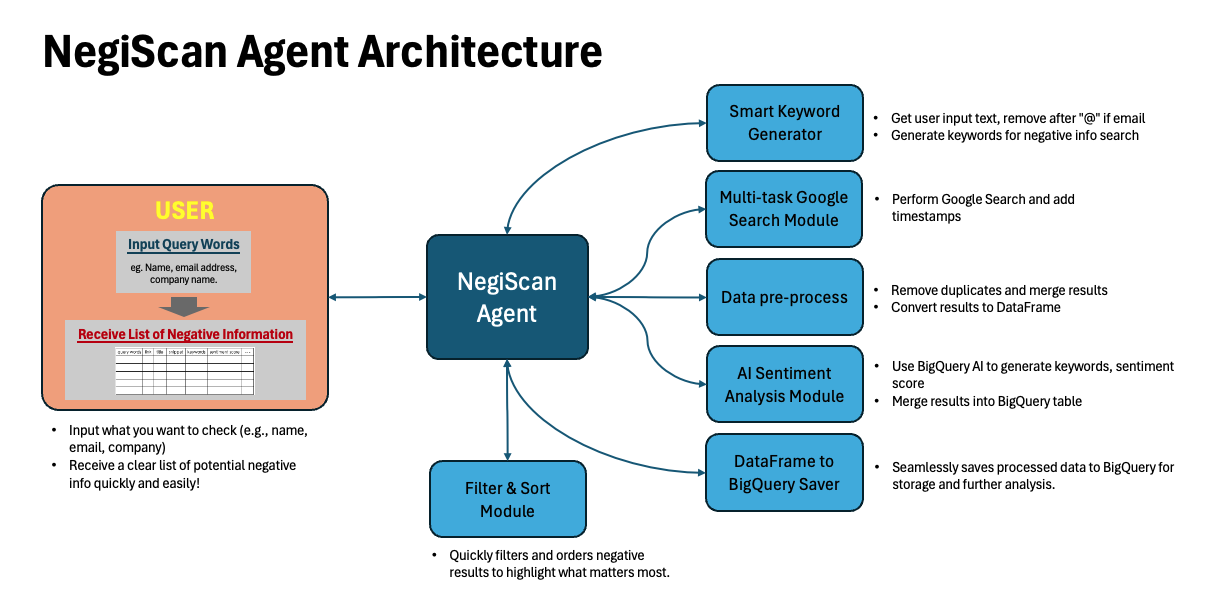



### 📝 Input Processing  
- Generates smart keyword variations from user input by extracting base keywords and combining them with relevant negative suffixes to maximize web search coverage. This module aligns with the keyword generation functions in the NegiScanAgent codebase that handle email splitting and query list creation dynamically.

### 🔎 Search Execution  
- Performs fast, parallelized Google Custom Search API queries using multi-threading to efficiently retrieve large volumes of search results. This corresponds to the `google_search` and `batch_google_search` modules, which asynchronously call Google APIs and collect results in batches for scalability.

### 🧹 Data Handling  
- Cleans and deduplicates raw search items to maintain high data quality and prevent redundant information storage. This matches the `deduplicate_results` method in the program that removes duplicate URLs before further processing.

### 📊 Data Structuring  
- Transforms cleaned results into pandas DataFrames for structured, programmatic analysis and persistence. The `convert_to_dataframe` function in the code creates tabular data formats for downstream handling and BigQuery integration.

### 🤖 Sentiment Analysis  
- Runs integrated large language model sentiment scoring directly in BigQuery via SQL MERGE operations to flag negative or risky content with fine granularity. This complex embedded AI enrichment corresponds to the `run_sentiment_analysis` module that invokes the cloud model and merges sentiment outputs with raw data tables.

### ☁️ Cloud Storage  
- Stores and continuously updates enriched search results on BigQuery to enable scalable, real-time access and querying. The `save_to_bigquery` method manages data persistence and keeps sentiment-enhanced entries up to date.

### 📈 Reporting  
- Provides querying and filtering functions to quickly surface the most critical negative findings for user review. This is implemented through BigQuery SQL queries that rank and return top adverse signals, supporting targeted decision-making.


---

##  **Key Benefits Integrated into the Solution**

- ⏳ Dramatically reduces manual search and review time by automating intelligent keyword generation, multi-threaded searches, and AI-driven processing.  
- 🕵️‍♂️ Detects risks sooner and captures more signals thanks to real-time sentiment analysis merging with scalable data storage.  
- 🔒 Enhances compliance, operational efficiency, and credit decision quality by providing auditable, data-driven negative information insights promptly accessible within existing credit and AML workflows.




---


---



# Environment Setup

In [1]:
!pip install --upgrade google-cloud-bigquery pandas-gbq

## Authenticate with Google

In [2]:
from google.colab import auth
auth.authenticate_user()

## Google Custom Search API Credentials

Before running this code, make sure you have:

1. A **Google Search API key**  
2. A **Custom Search Engine (CSE) ID**  

Then, store them in Colab’s **user data**.
Once these are set up, you can return to this notebook and execute the code.



In [3]:
import os
from google.colab import userdata

API_KEY = userdata.get('google_search_api')
CSE_ID = userdata.get('cse_id')

## BigQuery Project & Table

1. Obtain your **Project ID** from the Google Cloud Console (BigQuery project).  
2. The **Dataset ID** and **Table ID** can be created by your code during execution.  
3. Save the Project ID in Colab’s user data.
4. Run the notebook code which uses the Project ID to initialize the BigQuery client and create datasets or tables as needed.


In [4]:
project_id = userdata.get('project_id')
dataset_id = userdata.get('dataset_id')
table_id = userdata.get('table_id')

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

# Set project id
!gcloud config set project {project_id}

Updated property [core/project].


## BigQuery Cloud Resources Connection


In [6]:
!bq mk --connection --location=us --connection_type=CLOUD_RESOURCE bqc_connection

BigQuery error in mk operation: Already Exists: Connection
projects/1001183223524/locations/us/connections/bqc_connection


## Retrieve Service Account Permissions

In [7]:
SERVICE_ACCT = !bq show --format=prettyjson --connection us.bqc_connection | grep "serviceAccountId" | cut -d '"' -f 4
SERVICE_ACCT_EMAIL = SERVICE_ACCT[-1]
print('SERVICE_ACCT_EMAIL: ', '<SERVICE_ACCT_EMAIL>')

SERVICE_ACCT_EMAIL:  <SERVICE_ACCT_EMAIL>


## Project IAM Permissions
Ensure the Service Account can securely access relevant Google Cloud services




In [8]:
import time

## Grant BigQuery Connection User role
!gcloud projects add-iam-policy-binding --format=none {project_id} --member=serviceAccount:{SERVICE_ACCT_EMAIL} --role='roles/bigquery.connectionUser'

## Grant AI Platform User role
!gcloud projects add-iam-policy-binding --format=none {project_id} --member=serviceAccount:{SERVICE_ACCT_EMAIL} --role='roles/aiplatform.user'

# Wait 60 seconds for IAM changes to propagate
time.sleep(60)

Updated IAM policy for project [tough-plate-440414-i0].
Updated IAM policy for project [tough-plate-440414-i0].


# Set LLM Model Name

In [9]:
model_name = "bq_ai_tutorial.gemini_2_5_flash"

# NegiScanAgent

In [10]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
from googleapiclient.discovery import build
import pandas as pd
import pandas_gbq
from pandas_gbq import read_gbq
from concurrent.futures import ThreadPoolExecutor

class NegiScanAgent():

  def __init__(self, API_KEY, CSE_ID, project_id, dataset_id, table_id, model_name):
    self.api_key = API_KEY
    self.cse_id = CSE_ID
    self.project_id = project_id
    self.dataset_id = dataset_id
    self.table_id = table_id
    self.model_name = model_name

    ## Google Custom Search Service
    self.service = build("customsearch", "v1", developerKey = self.api_key)

  def split_email(self, email: str)-> str:
      if "@" in email:
        return email.split("@",1)[0]
      else:
        return email

  # Keyword generation module 關鍵字版本模組
  def generate_keyword_versions(self, user_input):
      # Extract part before '@' if email 先處理email前text
      user_input = self.split_email(user_input)
      # Generate negative keyword query list 生成負面關鍵字查詢列表
      base_keywords = [user_input]
      suffixes = ["被告","訴訟","消債","判決","負面","爭議","差評","負評","代辦","整合負債","貸款"]
      queries = []
      for base in base_keywords:
        queries.append(base)
        for suffix in suffixes:
          queries.append(f"{base} {suffix}")
      return queries

  # Muti-task Google Search Module 多任務搜尋模組
  def google_search(self, query, num = 10):
      try:
        res = self.service.cse().list(q=query, cx=self.cse_id, num=num).execute()
        items = res.get("items", [])

        utc_time = datetime.now(timezone.utc)
        tw_time = utc_time.astimezone(ZoneInfo("Asia/Taipei"))
        for item in items:
          item["query"] = query
          item["query_time_utc"] = utc_time.isoformat()
          item["query_time_tw"] = utc_time.isoformat()
        return items
      except Exception as e:
        print(f"Error in google_search: {e}")
      return []

  def batch_google_search(self, queries):
      results = []
      with ThreadPoolExecutor(max_workers=1) as executor:
        futures = [executor.submit(self.google_search, q) for q in queries]
        for future in futures:
          results.extend(future.result() or [])
      return results

  # Remove duplicates and merge results 資料去除重複與合併模組
  def deduplicate_results(self, items):
      seen = set()
      deduped = []
      for item in items:
        key = item['link']
        if key not in seen:
          deduped.append(item)
          seen.add(key)
      return deduped

  # Convert results to DataFrame 資料轉成DataFrame
  def convert_to_dataframe(self, items):
      rows = [dict(item) for item in items]
      df = pd.DataFrame(rows)
      # Initial columsn to avoid missing field errors 初始設定欄位，避免缺欄錯誤
      df["keywords"] = [[] for _ in range(len(df))]
      df["sentiment"] = None
      df["processed_flag"] = False
      return df

  # Run AI Sentiment analysis
  def run_sentiment_analysis(self, client):
      sql = f"""
      MERGE INTO `{self.dataset_id}.{self.table_id}` AS target
      USING (
        SELECT a.title, a.snippet, a.link, b.keywords, b.sentiment, b.query_time_tw
        FROM `{self.dataset_id}.{self.table_id}` AS a
        JOIN
        AI.GENERATE_TABLE(
          MODEL `{self.model_name}`,
          (
            SELECT title, snippet, link, query_time_tw,
                    CONCAT('Extract keywords and a sentiment score from text.',
                           'The sentiment score must be a single digit string from 1 to 5 inclusive, ',
                           'where 1 means negative and 5 means positive.',
                            title,
                            ' ',
                            snippet) AS prompt
            FROM `{self.dataset_id}.{self.table_id}`
            WHERE processed_flag IS NOT TRUE
          ) ,
          STRUCT(
            'keywords ARRAY<STRING>, sentiment STRING' AS output_schema,
            0.01 AS temperature,
            1000 AS max_output_tokens
          )
        ) AS b
        ON a.title = b.title AND a.snippet = b.snippet AND a.link = b.link and a.query_time_tw = b.query_time_tw
      ) AS source
      ON target.title = source.title AND target.snippet = source.snippet AND target.link = source.link AND target.query_time_tw = source.query_time_tw
      WHEN MATCHED THEN
      UPDATE SET target.keywords = source.keywords,
                target.sentiment = source.sentiment,
                target.processed_flag = TRUE;
      """
      try:
        query_job = client.query(sql)
        query_job.result()
        print(f"  ✅ Successfully wrote sentiment analysis results to BigQuery {self.project_id}.{self.dataset_id}.{self.table_id}")
      except Exception as e:
        print(f"Error in run_sentiment_analysis: {e}")

  # Filter and sort negative results 負面資訊排序與篩選模組
  def top_negative_results(df, top_n = 10):
      return df.sort_values('sentiment').head(top_n)

  # Clean column names 清理欄位名稱
  def clean_column_name(self, df):
      df.columns = [col.replace('.','_').replace(' ', '_') for col in df.columns]
      keep_columns = ['title', 'link', 'snippet', 'query', 'query_time_utc','query_time_tw', 'keywords', 'sentiment', 'processed_flag']
      return df[keep_columns]

  # Save DataFrame to BigQuery 儲存到 BigQuery
  def save_to_bigquery(self, df):
      df_clean = self.clean_column_name(df)
      try:
        pandas_gbq.to_gbq(df_clean, f"{self.dataset_id}.{self.table_id}", project_id = self.project_id, if_exists = 'append')
        print(f"  ✅ Saved {len(df_clean)} records to BigQuery {self.project_id}.{self.dataset_id}.{self.table_id}.")
      except Exception as e:
        print(f"❗Error save_to_bigquery failed: {e}")

  # Main execution function, calls sub-modules 主程式執行函式，串接子功能
  def run_all(self, client, user_input):

      print("▶ [Start] Generating keyword versions...")
      queries = self.generate_keyword_versions(user_input)

      print("▶ [Info] Starting batch Google Custom Searches...")
      items = self.batch_google_search(queries)

      if not items:
        print("❗[Warning] No results found.")
        return

      print("▶ [Info] Deduplicating search results...")
      deduped_items = self.deduplicate_results(items)

      print("▶ [Info] Converting results to DataFrame...")
      df = self.convert_to_dataframe(deduped_items)

      print("▶ [Info] Saving raw search results to BigQuery...")
      self.save_to_bigquery(df)

      print("▶ [Info] Running AI sentiment analysis...")
      self.run_sentiment_analysis(client)

      print("▶ [Info] Querying updated data from BigQuery for negative result filtering...")
      try:
        query = f"""
        WITH filtered_data AS (
          SELECT * FROM `{self.dataset_id}.{self.table_id}`
          WHERE query LIKE '{user_input}%'
        )
        SELECT * FROM filtered_data
        ORDER BY CAST(sentiment AS INT64) ASC
        LIMIT 10
        """
        df_updated = read_gbq(query, project_id = self.project_id)
        print("▶ [Info] Top negative results for current user input query.")
        print("▶▶▶ [End] Agent Task Completed.")
        print("")
        display(df_updated)
      except Exception as e:
        print(f"❗Error querying updated data: {e}")

# Run NegiScanAgent
An example of searching for my Chinese name is as follows.

In [11]:
agent = NegiScanAgent(API_KEY = API_KEY, CSE_ID = CSE_ID, project_id = project_id, dataset_id = dataset_id, table_id = table_id, model_name = model_name)

user_input = input("Please enter the text you want to search for. 請輸入欲查詢文字：")
agent.run_all(client, user_input = user_input)

Please enter the text you want to search for. 請輸入欲查詢文字：陳姿君
▶ [Start] Generating keyword versions...
▶ [Info] Starting batch Google Custom Searches...
▶ [Info] Deduplicating search results...
▶ [Info] Converting results to DataFrame...
▶ [Info] Saving raw search results to BigQuery...


100%|██████████| 1/1 [00:00<00:00, 2406.37it/s]


  ✅ Saved 101 records to BigQuery tough-plate-440414-i0.negi_scan_agent.search_result_with_sentiment.
▶ [Info] Running AI sentiment analysis...
  ✅ Successfully wrote sentiment analysis results to BigQuery tough-plate-440414-i0.negi_scan_agent.search_result_with_sentiment
▶ [Info] Querying updated data from BigQuery for negative result filtering...
Downloading: 100%|██████████|
▶ [Info] Top negative results for current user input query.
▶▶▶ [End] Agent Task Completed.



,title,link,snippet,query,query_time_utc,query_time_tw,keywords,sentiment,processed_flag
0,財團法人犯罪被害人保護協會臺灣屏東分會新聞稿-犯保屏東分會舉辦 ...,https://www.ptc.moj.gov.tw/media/315949/112041...,"Apr 11, 2023 ... 聯絡人：陳姿君 ... 「一通電話傳來消息，某位家人就在瞬...",陳姿君 被告,2025-09-19T14:37:20.945107+00:00,2025-09-19T14:37:20.945107+00:00,"[財團法人犯罪被害人保護協會臺灣屏東分會, 犯保屏東分會, 新聞稿, 馨生人, 後事, 司法...",1,True
1,1060425犯保屏東辦理志工特殊教育訓練～強化到位服務體現「犯保 ...,https://www.ptc.moj.gov.tw/media/140517/742511...,聯絡人：陳姿君. 聯絡電話：(08)7535255 ... 在他人生低潮時，面對家人的逝去，...,陳姿君 被告,2025-09-19T14:37:20.945107+00:00,2025-09-19T14:37:20.945107+00:00,"[犯保屏東, 志工特殊教育訓練, 人生低潮, 家人逝去, 滿目瘡痍, 生命苦難, 訴訟, 被...",1,True
2,2011.3.9 宿舍飲酒東海大學學生過失致死 - 社會事件檔案簿,http://taiwancourtnews.blogspot.com/2011/03/20...,"Mar 9, 2011 ... 30棟前見面，被告陳志恒遂與被告黃少伯、陳俊宏、李智忠 、許...",陳姿君 被告,2025-09-19T14:37:20.945107+00:00,2025-09-19T14:37:20.945107+00:00,"[宿舍飲酒, 東海大學, 學生過失致死, 社會事件檔案簿, 陳志恒, 黃少伯, 陳俊宏, 李...",1,True
3,請問我大概7年前有欠分別3家銀行卡債（花旗35萬/國泰世華6萬/華南 ...,https://www.facebook.com/groups/12648309472736...,"Jun 1, 2025 ... 去法院申請債務更生（但你的保單可能被取 消，慎用）。 3 mos.",陳姿君 消債,2025-09-19T14:37:21.795673+00:00,2025-09-19T14:37:21.795673+00:00,"[銀行卡債, 花旗, 國泰世華, 華南, 債務更生, 保單, 法院]",1,True
4,當聰明的狗遇上心理學教授，碰撞出的火花使他們名聞遐邇 ...,https://news.readmoo.com/2020/05/04/chaser-and...,"May 4, 2020 ... ... 陳姿君；出版社／四塊玉文創. ※內容為作者個人觀點，...",陳姿君 負評,2025-09-19T14:37:23.427758+00:00,2025-09-19T14:37:23.427758+00:00,"[聰明的狗, 心理學教授, 火花, 名聞遐邇, 陳姿君, 四塊玉文創, 一星負評, 踩雷]",1,True
5,郑婷瑄律师,https://oceanseeker.tw/%E9%83%91%E5%A9%B7%E7%9...,... 發稿日期：106 年12 月25 日聯絡人：陳姿君聯絡電話：(08)7535255 ...,陳姿君 被告,2025-09-19T15:45:35.614414+00:00,2025-09-19T15:45:35.614414+00:00,"[郑婷瑄律师, 海巡士官長, GPS, 查案, 拘役]",1,True
6,80歲翁鬧自殺警批社福單位效率差- 2013年04月11日｜ 公視新聞網PNN,https://news.pts.org.tw/article/237590,"Apr 11, 2013 ... 財劃法修法爭議 · 即時 · 熱門議題 · 影音 · 數位...",陳姿君 爭議,2025-09-19T15:45:38.911489+00:00,2025-09-19T15:45:38.911489+00:00,"[80歲翁, 自殺, 警批社福單位, 效率差, 自殺威脅, 情緒焦躁]",1,True
7,1060425犯保屏東辦理志工特殊教育訓練～強化到位服務體現「犯保 ...,https://www.ptc.moj.gov.tw/media/140517/742511...,聯絡人：陳姿君. 聯絡電話：(08)7535255 ... 在他人生低潮時，面對家人的逝去，...,陳姿君 被告,2025-09-19T15:45:35.614414+00:00,2025-09-19T15:45:35.614414+00:00,"[犯保屏東, 志工特殊教育訓練, 人生低潮, 家人逝去, 滿目瘡痍, 生命苦難, 訴訟, 被...",1,True
8,郑婷瑄律师,https://oceanseeker.tw/%E9%83%91%E5%A9%B7%E7%9...,... 發稿日期：106 年12 月25 日聯絡人：陳姿君聯絡電話：(08)7535255 ...,陳姿君 被告,2025-09-19T14:37:20.945107+00:00,2025-09-19T14:37:20.945107+00:00,"[郑婷瑄律师, 海巡士官長, GPS, 查案, 拘役]",1,True
9,80歲翁鬧自殺警批社福單位效率差- 2013年04月11日｜ 公視新聞網PNN,https://news.pts.org.tw/article/237590,"Apr 11, 2013 ... 財劃法修法爭議 · 即時 · 熱門議題 · 影音 · 數位...",陳姿君 爭議,2025-09-19T14:37:23.034780+00:00,2025-09-19T14:37:23.034780+00:00,"[80歲翁, 自殺, 警批社福單位, 效率差, 自殺威脅, 情緒焦躁]",1,True
